In [ ]:
!pip install transformers
!pip install seqeval

In [2]:
import pandas as pd
from collections import defaultdict, Counter
import os
from itertools import chain
import sklearn.preprocessing as skp
import time
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
###importnat###
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tqdm import tqdm, trange

import transformers
from transformers import BertForTokenClassification, AdamW
from transformers import get_linear_schedule_with_warmup

#from seqeval.metrics import f1_score, accuracy_score, classification_report
from sklearn.metrics import classification_report

In [3]:
def from_file(file_path: str):
    """
    Read data from a conll encoded text file and represent it as pandas DF with two columns: (for the
    input sequences and for the labels)
    :param file_path: str: the path to the file
    :return: pd.DataFrame
    """
    dataset_predictors = defaultdict(list)
    dataset_labels = defaultdict(list)
    sentence_count = 0
    with open(file_path,'r') as f:
        for line in f:
            if line=='\n':
                sentence_count+=1
                continue
            predictor, label = line.split(' ')
            dataset_predictors[sentence_count].append(predictor.strip())
            dataset_labels[sentence_count].append(label.strip())
    df = pd.DataFrame([dataset_predictors, dataset_labels]).T
    df.dropna(inplace=True)
    df.columns = ['predictors', 'labels']
    return df


def from_dir(data_path):
    """
    Wrapper around the from file function to process multiple conll files in a directory. Additional
    column is added: the file column holding the name of the file. Could be used for stratified split.
    :param data_path: str: path to the directory
    :return: pd.DataFrame
    """
    global_dataset = []
    for file in os.listdir(data_path):
        if not file.endswith('.conll'):
            continue
        file_path = os.path.join(data_path, file)
        df = from_file(file_path)
        df['file'] = file.split('.')[0]
        global_dataset.append(df)

    return pd.concat(global_dataset).dropna()

In [4]:
%%time
dataset = from_dir('data')

CPU times: user 5.28 s, sys: 98.3 ms, total: 5.38 s
Wall time: 5.4 s


In [61]:
dataset.sample(2)

,predictors,labels,file
6066,"[Komplementärin, der, KG, ohne, Kapitalbeteili...","[O, O, O, O, O, O, O, O, O, O, O, O, B-UN, I-U...",bfh
4590,"[Daher, stellt, nicht, jede, Verletzung, der, ...","[O, O, O, O, O, O, O, O, O, O, O, O, B-GS, I-G...",bverfg


In [49]:
tag = []
for i in dataset['labels']:
  for j in i:
    tag.append(j)
# Create a dictionary containing the tags and the corresponding index
tags2vals = list(set(tag))
print(tags2vals)
tag2idx = {t: i for i, t in enumerate(tags2vals)}
print(tag2idx)

['B-ORG', 'B-LDS', 'I-RR', 'B-PER', 'I-LIT', 'I-AN', 'I-UN', 'I-EUN', 'I-INN', 'B-VT', 'I-LD', 'I-GRT', 'B-RR', 'I-VS', 'B-STR', 'B-INN', 'B-VO', 'I-GS', 'B-LIT', 'I-STR', 'B-LD', 'B-MRK', 'I-LDS', 'I-VT', 'I-PER', 'B-GRT', 'B-RS', 'B-GS', 'I-MRK', 'I-ST', 'O', 'B-AN', 'B-ST', 'B-UN', 'I-VO', 'I-RS', 'B-EUN', 'I-ORG', 'B-VS']
{'B-ORG': 0, 'B-LDS': 1, 'I-RR': 2, 'B-PER': 3, 'I-LIT': 4, 'I-AN': 5, 'I-UN': 6, 'I-EUN': 7, 'I-INN': 8, 'B-VT': 9, 'I-LD': 10, 'I-GRT': 11, 'B-RR': 12, 'I-VS': 13, 'B-STR': 14, 'B-INN': 15, 'B-VO': 16, 'I-GS': 17, 'B-LIT': 18, 'I-STR': 19, 'B-LD': 20, 'B-MRK': 21, 'I-LDS': 22, 'I-VT': 23, 'I-PER': 24, 'B-GRT': 25, 'B-RS': 26, 'B-GS': 27, 'I-MRK': 28, 'I-ST': 29, 'O': 30, 'B-AN': 31, 'B-ST': 32, 'B-UN': 33, 'I-VO': 34, 'I-RS': 35, 'B-EUN': 36, 'I-ORG': 37, 'B-VS': 38}


In [6]:
# sequence length: 100 tokens
MAX_LEN = 100
# batch size: 32
bs = 32

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [8]:
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [9]:
#define a tokenizer with pretrained modell 'bert-base-cased' 
tokenizer = BertTokenizer.from_pretrained('bert-base-german-cased', do_lower_case=False)

In [10]:
# Build a function, that tokenize all sentences in tokens and all tokens in subword tokens
def bert_tokenizer(sentence, labels):
  tokenizer_final = []
  labels_final = []

  for token, label in zip(sentence, labels):
    # Use bert tokeniser
    sub_token = tokenizer.tokenize(token)
    subtoken_len = len(sub_token)
    tokenizer_final.extend(sub_token)
    labels_final.extend([label] * subtoken_len)

  return tokenizer_final, labels_final

In [11]:
tokenizerbert = [bert_tokenizer(sent, label) for sent, label in zip(dataset['predictors'], dataset['labels'])]

In [12]:
tokenized_texts = [token_label[0] for token_label in tokenizerbert]
labels = [token_label[1] for token_label in tokenizerbert]

In [14]:
print(tokenized_texts[10])
print(labels[10])

['Die', 'Marken', '##stelle', 'für', 'Klasse', '5', 'des', 'Deutschen', 'Patent', '-', 'und', 'Marken', '##amts', 'hat', 'mit', 'den', 'Beschlüsse', '##n', 'vom', '20', '.', 'Januar', '2015', 'und', 'vom', '2', '.', 'März', '2016', ',', 'von', 'denen', 'Letztere', '##r', 'im', 'Erinnerungs', '##verfahren', 'ergangen', 'ist', ',', 'die', 'Gefahr', 'der', 'Verw', '##echs', '##lung', 'im', 'Sinne', 'des', '§', '9', 'Abs', '.', '1', 'Nr', '.', '2', 'Marken', '##G', 'zwischen', 'den', 'sich', 'gegenüber', '##stehenden', 'Marken', 'bejaht', 'und', 'die', 'Lösch', '##ung', 'der', 'angegriffenen', 'Marke', 'angeordnet', '.']
['O', 'B-INN', 'B-INN', 'I-INN', 'I-INN', 'I-INN', 'I-INN', 'I-INN', 'I-INN', 'I-INN', 'I-INN', 'I-INN', 'I-INN', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-GS', 'I-GS', 'I-GS', 'I-GS', 'I-GS', 'I-GS', 'I-GS', 'I-GS', 'I-GS', 'I-GS', '

In [13]:
# Convert input text to indices
predictors2idx = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts], maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [16]:
print(predictors2idx[10])

[  125  8443  1947   142  5546   435    91  1700 10895 26935    42  8443
  8517   193   114    86 10246 26898   275   148 26914  1201  1496    42
   275    99 26914  1228  1712 26918    88  1304 20036 26900   106 24449
  2668 16245   127 26918    30  4445    21 17646 15970   593   106  1987
    91 26967   763   423 26914    62  1247 26914    99  8443 26930   597
    86   144  1653  6094  8443 24299    42    30 25086    27    21 12029
  7702  9451 26914     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]


In [14]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels], maxlen=MAX_LEN, value=tag2idx["O"], padding="post",
                     dtype="long", truncating="post")

In [18]:
print(tags[10])

[37 17 17  5  5  5  5  5  5  5  5  5  5 37 37 37 37 37 37 37 37 37 37 37
 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37
 37 32 33 33 33 33 33 33 33 33 33 37 37 37 37 37 37 37 37 37 37 37 37 37
 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37
 37 37 37 37]


In [15]:
# Create an attention mask to ignore the padded elements in the sequences
attention_mask = [[float(i != 0.0) for i in ii] for ii in predictors2idx]

In [20]:
print(attention_mask[1])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [16]:
# Split the dataset
# 20% for validation
X_train, X_test, Y_train, Y_test = train_test_split(predictors2idx, tags,random_state=1, test_size=0.2)
M_train, M_test, _, _ = train_test_split(attention_mask, predictors2idx,random_state=1, test_size=0.2)

In [17]:
# Convert the dataset to torch tensors
train_feat = torch.tensor(X_train)
test_feat = torch.tensor(X_test)
train_labels = torch.tensor(Y_train)
test_labels = torch.tensor(Y_test)
train_mask = torch.tensor(M_train)
test_mask = torch.tensor(M_test)

In [21]:
print(train_feat.shape)
print(test_feat.shape)
print(train_labels.shape)
print(test_labels.shape)
print(train_mask.shape)
print(test_mask.shape)

torch.Size([53378, 100])
torch.Size([13345, 100])
torch.Size([53378, 100])
torch.Size([13345, 100])
torch.Size([53378, 100])
torch.Size([13345, 100])


In [18]:
# Define the dataloaders
# Shuffle the data at training time with the RandomSampler
train_data = TensorDataset(train_feat, train_mask, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

# Pass the data at the test time sequentially with the SequentialSampler
test_data = TensorDataset(test_feat, test_mask, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=bs)

In [19]:
# Build the model
# Use the BertForTokenClassification that wraps BertModel and adds token-level classifier on top of the BertModel
# Load the pretrained 'bert-base-cased' model and provide the number of possible labels
model = BertForTokenClassification.from_pretrained(
    "bert-base-german-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-b

In [20]:
model.cuda();

In [21]:
# Define a fine-tuning process with adding some weight_decay as regularization to the main weight matrices
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
    
# Define an AdamW optimizer
optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

In [22]:
epochs = 3
max_grad_norm = 1.0

# Total number of training steps
total_steps = len(train_dataloader) * epochs
# Define a scheduler to linearly reduce the learning rate throughout the epochs
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,num_training_steps=total_steps)

In [41]:
def list_shape(input):
    
    shape = []
    a = len(input)
    shape.append(a)
    b = input[0]

    while a > 0:
        try:

            a = len(b)
            shape.append(a)
            b = b[0]

        except:
            break
        
    return shape

In [62]:
loss_values, validation_loss_values = [], []
validation_accuracy = []
classification_report_eval = []

for _ in trange(epochs, desc="Epoch"):
  # ========================================
  #               Training
  # ========================================   
  
  model.train()
  total_loss = 0

  for step, batch in enumerate(train_dataloader):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    model.zero_grad()
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs[0]
    loss.backward()
    total_loss += loss.item()
    torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
    optimizer.step()
    scheduler.step()

  avg_train_loss = total_loss / len(train_dataloader)
  print("Average train loss: {}".format(avg_train_loss))
  loss_values.append(avg_train_loss)
  
  # ========================================
  #               Validation
  # ========================================
  model.eval()
  predictions = []
  true_labels = []
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        
    logits = outputs[1].detach().cpu().numpy()
    predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
    label_ids = b_labels.to('cpu').numpy()
    true_labels.append(label_ids)
    eval_loss += outputs[0].mean().item()
    nb_eval_steps += 1  
  
  p = []
  for p_i in predictions:
    for p_ii in p_i:
      p.append(p_ii) 
  k = [tr_i for t in true_labels for tr_i in t]
  true = []
  for i in k:
    for ii in i:
      true.append(ii) 
  eval_loss_final = eval_loss/nb_eval_steps
  print("Validation loss: {}".format(eval_loss_final))
  validation_loss_values.append(eval_loss_final)
  class_report = classification_report(true,p,target_names=tags2vals)
  print("\nClassification-Report:\n", class_report)
  classification_report_eval.append(class_report)
  print()


















Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Average train loss: 0.032616286307018516
Validation loss: 0.02564521881820263


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

















Epoch:  33%|███▎      | 1/3 [10:10<20:20, 610.44s/it]


Classification-Report:
               precision    recall  f1-score   support

       B-ORG       0.54      0.75      0.63       472
       B-LDS       0.45      0.32      0.37        60
        I-RR       0.04      0.72      0.08        43
       B-PER       0.35      0.91      0.50       512
       I-LIT       0.67      0.97      0.79      6897
        I-AN       0.00      0.00      0.00        15
        I-UN       0.48      0.95      0.64       370
       I-EUN       0.72      0.95      0.82      2829
       I-INN       0.52      0.96      0.68      1384
        B-VT       0.50      0.94      0.65       988
        I-LD       0.86      0.84      0.85        92
       I-GRT       0.63      0.92      0.75       738
        B-RR       0.03      0.97      0.06       597
        I-VS       0.51      0.95      0.67      1158
       B-STR       0.49      0.80      0.61        49
       B-INN       0.66      0.92      0.77       848
        B-VO       0.49      0.93      0.64       282
  


















Epoch:  67%|██████▋   | 2/3 [20:18<10:09, 609.85s/it]


Classification-Report:
               precision    recall  f1-score   support

       B-ORG       0.55      0.78      0.64       472
       B-LDS       0.55      0.57      0.56        60
        I-RR       0.08      0.98      0.15        43
       B-PER       0.41      0.92      0.57       512
       I-LIT       0.70      0.96      0.81      6897
        I-AN       1.00      0.20      0.33        15
        I-UN       0.51      0.96      0.67       370
       I-EUN       0.75      0.95      0.84      2829
       I-INN       0.53      0.95      0.68      1384
        B-VT       0.50      0.96      0.66       988
        I-LD       0.89      0.85      0.87        92
       I-GRT       0.62      0.96      0.75       738
        B-RR       0.03      0.99      0.06       597
        I-VS       0.62      0.91      0.74      1158
       B-STR       0.58      0.76      0.65        49
       B-INN       0.57      0.97      0.72       848
        B-VO       0.46      0.96      0.62       282
  


















Epoch: 100%|██████████| 3/3 [30:26<00:00, 608.83s/it]


Classification-Report:
               precision    recall  f1-score   support

       B-ORG       0.55      0.80      0.65       472
       B-LDS       0.54      0.70      0.61        60
        I-RR       0.09      0.98      0.16        43
       B-PER       0.41      0.92      0.57       512
       I-LIT       0.70      0.97      0.81      6897
        I-AN       0.93      0.87      0.90        15
        I-UN       0.53      0.97      0.69       370
       I-EUN       0.74      0.96      0.83      2829
       I-INN       0.52      0.97      0.68      1384
        B-VT       0.48      0.97      0.64       988
        I-LD       0.87      0.86      0.86        92
       I-GRT       0.62      0.97      0.76       738
        B-RR       0.03      0.99      0.06       597
        I-VS       0.59      0.93      0.73      1158
       B-STR       0.56      0.76      0.64        49
       B-INN       0.59      0.96      0.73       848
        B-VO       0.47      0.96      0.63       282
  

In [69]:
def plot_classification_report(cr, title='Classification report ', with_avg_total=True, cmap=plt.cm.RdPu):

  lines = cr.split('\n')
  classes = []
  plotMat = []
  for line in lines[2 : (len(lines)-5)]:
    t = line.split()
    classes.append(t[0])
    v = [float(x) for x in t[1: len(t)-1]]
    plotMat.append(v)

  if with_avg_total:
    for line in lines[len(lines)-3 : len(lines)-1]:
      aveTotal = line.split()
      classes.append(' '.join(aveTotal[:2]))
      vAveTotal = [float(x) for x in aveTotal[2:len(aveTotal) - 1]]
      plotMat.append(vAveTotal)

  plt.imshow(plotMat, interpolation='nearest', cmap=cmap)
  plt.gcf().set_size_inches(10, 10)
  plt.title(title)
  plt.colorbar()
  x_tick_marks = np.arange(3)
  y_tick_marks = np.arange(len(classes))
  plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
  plt.yticks(y_tick_marks, classes)
  plt.tight_layout()
  plt.ylabel('Classes')
  plt.xlabel('Measures')

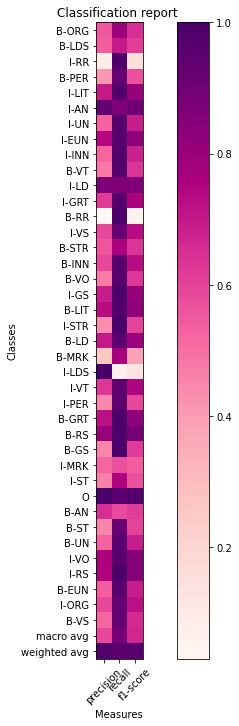

In [70]:
plot_classification_report(classification_report_eval[2])